In [1]:
# Install required libraries
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from datetime import datetime, timedelta

In [5]:
# Download NVIDIA stock data
ticker = "NVDA"
start_date = "2015-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
print(f"Downloading NVIDIA stock data from {start_date} to {end_date}...")
data = yf.download(ticker, start=start_date, end=end_date)
print("Data downloaded successfully!")

/tmp/ipython-input-1960308778.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!


In [6]:
# Display dataset info
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nDataset info:")
print(data.info())

Dataset shape: (2685, 5)

First few rows:
Price          Close      High       Low      Open     Volume
Ticker          NVDA      NVDA      NVDA      NVDA       NVDA
Date                                                         
2015-01-02  0.483066  0.486665  0.475386  0.483066  113680000
2015-01-05  0.474906  0.484505  0.472747  0.483066  197952000
2015-01-06  0.460508  0.476106  0.460028  0.475626  197764000
2015-01-07  0.459308  0.467947  0.457868  0.463868  321808000
2015-01-08  0.476586  0.479466  0.464348  0.464588  283780000

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2685 entries, 2015-01-02 to 2025-09-05
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, NVDA)   2685 non-null   float64
 1   (High, NVDA)    2685 non-null   float64
 2   (Low, NVDA)     2685 non-null   float64
 3   (Open, NVDA)    2685 non-null   float64
 4   (Volume, NVDA)  2685 non-null   int64  
dtypes: 

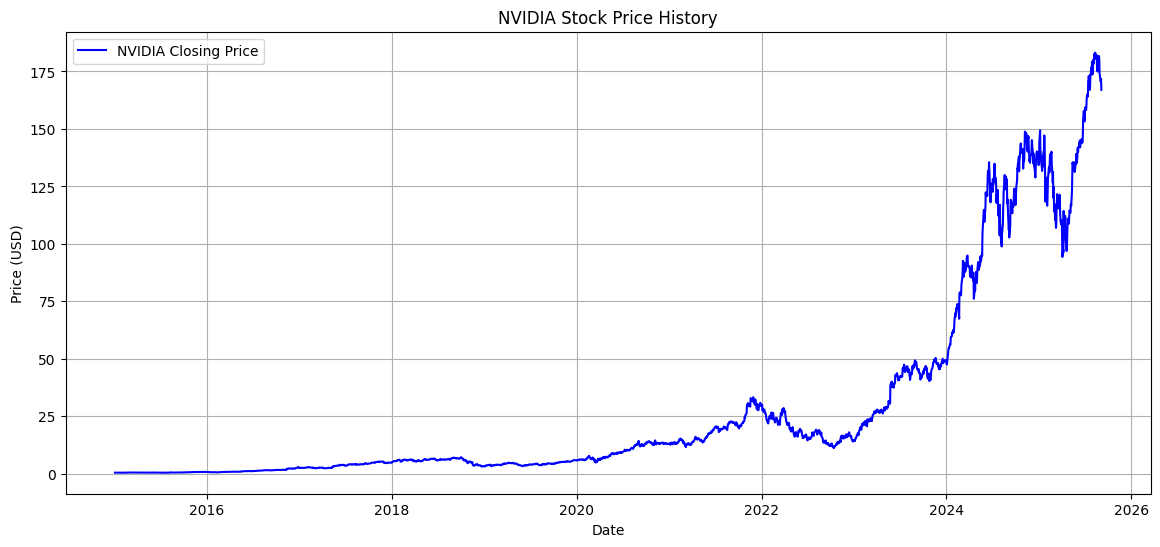

In [7]:
# Visualize the stock price history
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='NVIDIA Closing Price', color='blue')
plt.title('NVIDIA Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Prepare data for LSTM
# We'll use closing price for prediction
close_prices = data['Close'].values.reshape(-1, 1)

In [9]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [10]:
# Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

Training data size: 2148
Testing data size: 537


In [11]:
# Function to create dataset with time steps
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

In [12]:
# Time step - using 60 days of historical data to predict the next day
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2088, 60, 1)
y_train shape: (2088,)
X_test shape: (477, 60, 1)
y_test shape: (477,)


In [26]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['accuracy','mae', 'mse']  # Mean Absolute Error and Mean Squared Error
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.0000e+00 - loss: 0.0012 - mae: 0.0229 - mse: 0.0012 - val_accuracy: 0.0021 - val_loss: 0.0025 - val_mae: 0.0397 - val_mse: 0.0025
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.0000e+00 - loss: 1.1913e-04 - mae: 0.0065 - mse: 1.1913e-04 - val_accuracy: 0.0021 - val_loss: 0.0105 - val_mae: 0.0839 - val_mse: 0.0105
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0000e+00 - loss: 1.1559e-04 - mae: 0.0069 - mse: 1.1559e-04 - val_accuracy: 0.0021 - val_loss: 0.0021 - val_mae: 0.0355 - val_mse: 0.0021
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.0000e+00 - loss: 8.8804e-05 - mae: 0.0060 - mse: 8.8804e-05 - val_accuracy: 0.0021 - val_loss: 0.0023 - val_mae: 0.0389 - val_mse: 0.0023
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.0000e+00 - loss: 8.5411e-05 - mae: 0.0061 - mse: 8.5411e-05 - val_accuracy: 0.0021 - val_loss: 0.0020 - val_mae: 0.0355 - val_mse: 

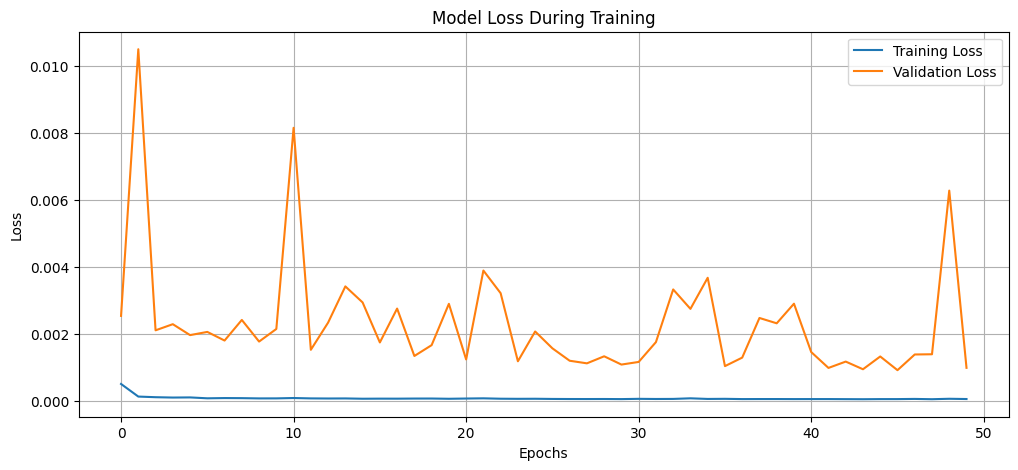

In [31]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [33]:
# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

In [34]:
# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:,0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:,0])
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Training RMSE: 0.85
Testing RMSE: 5.71
Training MAE: 0.62
Testing MAE: 4.41


In [35]:
# Plot the results
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, :] = train_predict

In [36]:
# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2):len(scaled_data), :] = test_predict

In [37]:
# Inverse transform the actual data
actual_prices = scaler.inverse_transform(scaled_data)

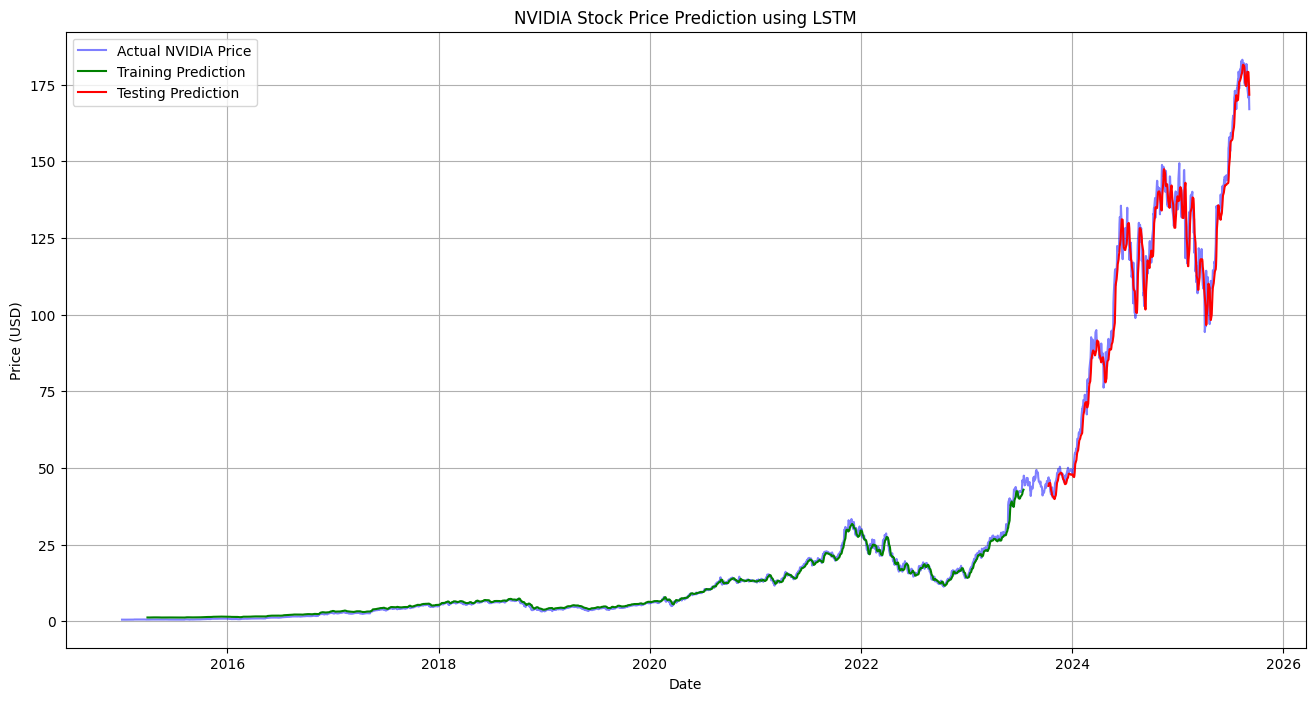

In [38]:
# Plot
plt.figure(figsize=(16, 8))
plt.plot(data.index, actual_prices, label='Actual NVIDIA Price', color='blue', alpha=0.5)
plt.plot(data.index, train_predict_plot, label='Training Prediction', color='green')
plt.plot(data.index, test_predict_plot, label='Testing Prediction', color='red')
plt.title('NVIDIA Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

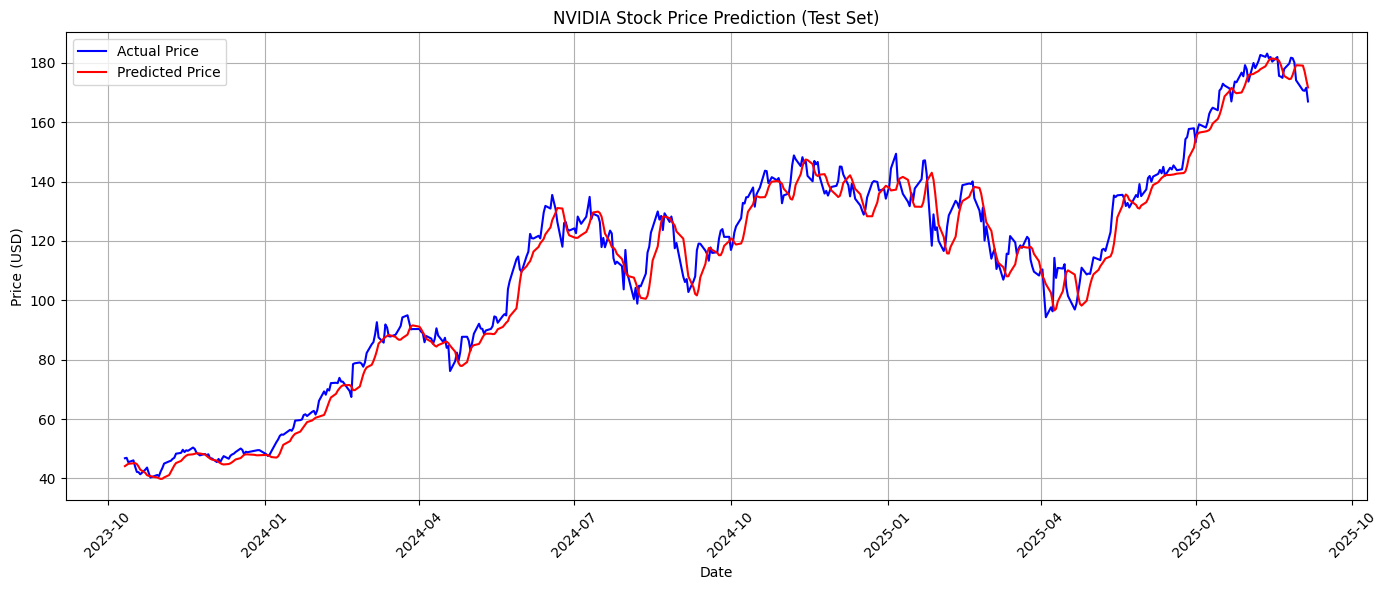

In [39]:
# Zoom in on the test period
test_dates = data.index[-len(y_test_actual[0]):]
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual[0], label='Actual Price', color='blue')
plt.plot(test_dates, test_predict[:,0], label='Predicted Price', color='red')
plt.title('NVIDIA Stock Price Prediction (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Predict future prices
def predict_future_prices(model, last_sequence, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, time_step, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    return np.array(future_predictions)
# Get the last sequence from the test data
last_sequence = X_test[-1].flatten()

# Predict next 30 days
future_days = 30
future_predictions = predict_future_prices(model, last_sequence, future_days)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

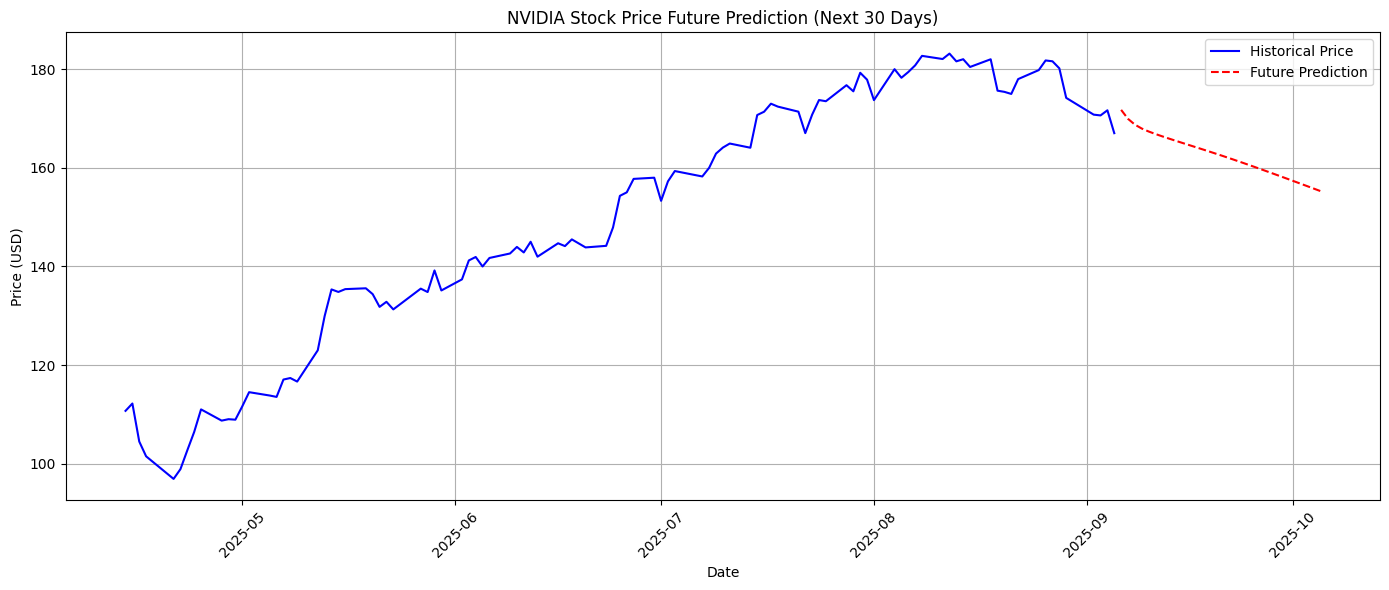

In [44]:
# Create future dates
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days+1)]

# Plot future predictions
plt.figure(figsize=(14, 6))
# Plot historical data (last 100 days)
plt.plot(data.index[-100:], data['Close'].values[-100:], label='Historical Price', color='blue')
# Plot future predictions
plt.plot(future_dates, future_predictions, label='Future Prediction', color='red', linestyle='--')
plt.title('NVIDIA Stock Price Future Prediction (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# Display future predictions in a table
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})
print("Predicted NVIDIA Stock Prices for the Next 30 Days:")
print(future_df.round(2))

Predicted NVIDIA Stock Prices for the Next 30 Days:
         Date  Predicted_Price
0  2025-09-06       171.750000
1  2025-09-07       169.929993
2  2025-09-08       168.750000
3  2025-09-09       167.960007
4  2025-09-10       167.360001
5  2025-09-11       166.850006
6  2025-09-12       166.369995
7  2025-09-13       165.910004
8  2025-09-14       165.460007
9  2025-09-15       165.009995
10 2025-09-16       164.559998
11 2025-09-17       164.119995
12 2025-09-18       163.679993
13 2025-09-19       163.229996
14 2025-09-20       162.770004
15 2025-09-21       162.309998
16 2025-09-22       161.839996
17 2025-09-23       161.360001
18 2025-09-24       160.880005
19 2025-09-25       160.389999
20 2025-09-26       159.889999
21 2025-09-27       159.389999
22 2025-09-28       158.889999
23 2025-09-29       158.380005
24 2025-09-30       157.869995
25 2025-10-01       157.360001
26 2025-10-02       156.839996
27 2025-10-03       156.330002
28 2025-10-04       155.809998
29 2025-10-05     